In [1056]:
import pandas as pd
from sklearn.model_selection import train_test_split
import json

In [1057]:
# reads in the json file, only to the max entries and returns them as json_array, if max entries is set to 0 then it reads the full thing
def read_partial_json_file(filename, max_entries=0, encoding='utf-8'):
    json_array = []
    with open(filename, 'r', encoding=encoding) as file:
        if max_entries == 0:
            for line in file:
                json_array.append(json.loads(line))
        else:
            for _ in range(max_entries):
                line = file.readline()
                if not line:
                    break
                json_array.append(json.loads(line))
    return json_array

def add_missing_keys(json_array):
    for obj in json_array:
        for key in ['stars', 'useful', 'funny', 'cool', 'text']:
            if key not in obj:
                obj[key] = 0
                print("Key {} not found in json".format(key))
    return json_array

# removes specified keys from json array
def remove_keys(json_array, keys_to_remove):
    for obj in json_array:
        for key in keys_to_remove:
            obj.pop(key, None)
    return json_array

def ConvertJSONFileToDataFrame(filename, max_entries=1000, encoding='utf-8'):
    #load in the json array
    json_array = read_partial_json_file(filename, max_entries, encoding)
    #add in the missing keys, will set to 0 for now but a heuristic for this will have to be made.
    json_array = add_missing_keys(json_array)
    df = pd.DataFrame(json_array)
    ColumnsToRemove = ['business_id', 'user_id', 'date', 'review_id']
    df = df.drop(columns=ColumnsToRemove)
    return df

In [1058]:

filename = 'yelp_academic_dataset_review.json'
df = ConvertJSONFileToDataFrame(filename, max_entries=5000)
df.head(10)

,stars,useful,funny,cool,text
0,3.0,0,0,0,"If you decide to eat here, just be aware it is..."
1,5.0,1,0,1,I've taken a lot of spin classes over the year...
2,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...
3,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo..."
4,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...
5,1.0,1,2,1,I am a long term frequent customer of this est...
6,5.0,0,2,0,Loved this tour! I grabbed a groupon and the p...
7,5.0,2,0,0,Amazingly amazing wings and homemade bleu chee...
8,3.0,1,1,0,This easter instead of going to Lopez Lake we ...
9,3.0,0,0,0,Had a party of 6 here for hibachi. Our waitres...


In [1059]:
train, validation = train_test_split(df, test_size=0.2, random_state=4, shuffle=True)

In [1060]:
train, test = train_test_split(train, test_size=0.25, random_state=89, shuffle=True)

In [1061]:
df = train.groupby(by='stars').agg('count').reset_index()

In [1062]:
len(validation)

1000

## Pickles Setup

In [1063]:
# Local names of files for Pickles. Putting valid pickle names runs the pickle
pickleFileMultinomialNB = ''

In [1064]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, mean_squared_error, ConfusionMatrixDisplay

## Count the totals fo each star rating

In [1065]:
oneCount = int((df.loc[df['stars']==1.0]['text'].astype(int)).iloc[0])
twoCount = int((df.loc[df['stars']==2.0]['text'].astype(int)).iloc[0])
threeCount = int((df.loc[df['stars']==3.0]['text'].astype(int)).iloc[0])
fourCount = int((df.loc[df['stars']==4.0]['text'].astype(int)).iloc[0])
fiveCount = int((df.loc[df['stars']==5.0]['text'].astype(int)).iloc[0])

## Get total counts and starting probabilities

In [1066]:
# Probability distribution
totalCount = oneCount + twoCount + threeCount + fourCount + fiveCount
p_catagory = {'1.0':oneCount/totalCount,'2.0':twoCount/totalCount,'3.0':threeCount/totalCount,'4.0':fourCount/totalCount,'5.0':fiveCount/totalCount}
ps_catagory = [float(oneCount/totalCount),twoCount/totalCount,threeCount/totalCount,fourCount/totalCount,fiveCount/totalCount]

In [1067]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

In [1068]:
bigDict = [{},{},{},{},{}]
allwords = {}

## Organize, Set Probability Dictionaries, Sum

In [1069]:
for row_index, row in train.iterrows():
    c = int(row["stars"])-1
    if(c == -1):
        print("WARNING!")
    content = row['text']
    for word in content.lower().split():
        if word in bigDict[c]:
            bigDict[c][word] += 1.0
        else:
            bigDict[c][word] = 1.0
        if word not in allwords:
            allwords[word] = 1.0
        else:
            allwords[word] += 1.0


for word in allwords.keys():
    for dict in bigDict:
        if word in dict:
            dict[word] += 1.0
        else:
            dict[word] = 1.0

## Fine Tune, Remove 1 Sums and Abundant Classifiers

In [1070]:
# Discard all 1 mentions
allwordssorted = {k: v for k, v in sorted(allwords.items(), key=lambda item: item[1])}
from math import floor
threshold = list(allwordssorted.keys())[floor(len(allwordssorted)*0.98)]
lowThreshold = list(allwordssorted.keys())[floor(len(allwordssorted)*0.02)]
toDelete = []
for word in allwordssorted.keys():
    if allwordssorted[word] <= allwordssorted[lowThreshold]:
        toDelete.append(word)
    elif allwordssorted[word] > allwordssorted[threshold]:
        toDelete.append(word)

for word in toDelete:
    del(allwordssorted[word])
    for cat in bigDict:
        del(cat[word])
    del(allwords[word])

## Normalize

In [1071]:
# Normalize
for dict in bigDict:
    totalCount = 0
    for word in dict:
        totalCount += dict[word]
    for word in dict:
        dict[word] = float(dict[word]) / (float(totalCount)+len(allwords))

## Train Model

In [1072]:
predictionSet = []
# Build Train Model
for row_index, row in test.iterrows():
    actual = row["stars"]
    content = row['text']
    p_chance = ps_catagory.copy()
    for w in content.lower().split():
        for i in range(5):
            if w in bigDict[i]:
                p_chance[i] = float(p_chance[i] * (bigDict[i][w]))
    pred = p_chance.index(max(p_chance))
    if(pred == 0):
        predictionSet.append(1.0)
    elif(pred==1):
        predictionSet.append(2.0)
    elif(pred==2):
        predictionSet.append(3.0)
    elif(pred==3):
        predictionSet.append(4.0)
    elif(pred==4):
        predictionSet.append(5.0)
        

## Output Accuracy, Confusion Matrix

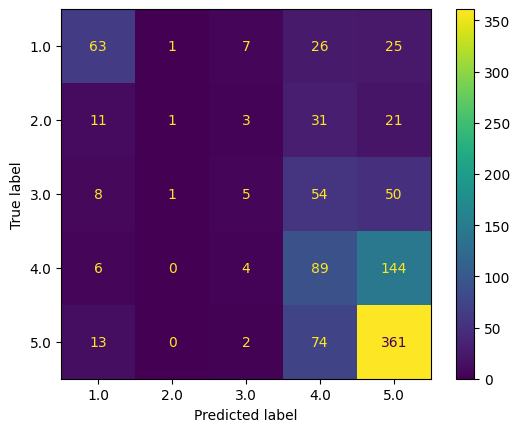

In [1073]:
from matplotlib import pyplot as plt
cm = confusion_matrix(test['stars'], predictionSet, labels=[1.0,2.0,3.0,4.0,5.0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[1.0,2.0,3.0,4.0,5.0])
disp.plot()
plt.show()

In [1074]:
print(classification_report(test['stars'], predictionSet))

              precision    recall  f1-score   support

         1.0       0.62      0.52      0.57       122
         2.0       0.33      0.01      0.03        67
         3.0       0.24      0.04      0.07       118
         4.0       0.32      0.37      0.34       243
         5.0       0.60      0.80      0.69       450

    accuracy                           0.52      1000
   macro avg       0.42      0.35      0.34      1000
weighted avg       0.48      0.52      0.47      1000



In [1075]:
from sklearn import linear_model
from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.preprocessing import  OneHotEncoder

## Setup Regressions

In [1076]:
lengther = len(train['cool'])
targetVectorCool = [0] * lengther
targetVectorUseful = [0] * lengther
targetVectorFunny = [0] * lengther
for i in range(lengther):
    targetVectorCool[i] = train.iloc[i]['cool']
    targetVectorUseful[i] = train.iloc[i]['useful']
    targetVectorFunny[i] = train.iloc[i]['funny']

## Preprocess input, Fit Data, Output

In [1077]:
vectorizer = CountVectorizer(stop_words='english',  ngram_range=(1, 1), dtype='double')
data = vectorizer.fit_transform(train['text'])
pca = decomposition.TruncatedSVD(n_components=50)
data = pca.fit_transform(data)

In [1078]:
regressionCool = linear_model.BayesianRidge()
regressionCool.fit(data,targetVectorCool)
predictCool = regressionCool.predict(pca.fit_transform(vectorizer.fit_transform(test['text'])))
mean_squared_error(test['cool'], predictCool)

1.4197978102239937

In [1079]:
regressionUseful = linear_model.BayesianRidge()
regressionUseful.fit(data,targetVectorUseful)
predictUseful = regressionCool.predict(pca.fit_transform(vectorizer.fit_transform(test['text'])))
mean_squared_error(test['useful'], predictUseful)

2.67471840375785

In [1080]:
regressionFunny = linear_model.BayesianRidge()
regressionFunny.fit(data,targetVectorFunny)
predictFunny = regressionCool.predict(pca.fit_transform(vectorizer.fit_transform(test['text'])))
mean_squared_error(test['funny'], predictFunny)

1.1508126005200074

## Graph Linear Regression Graphs

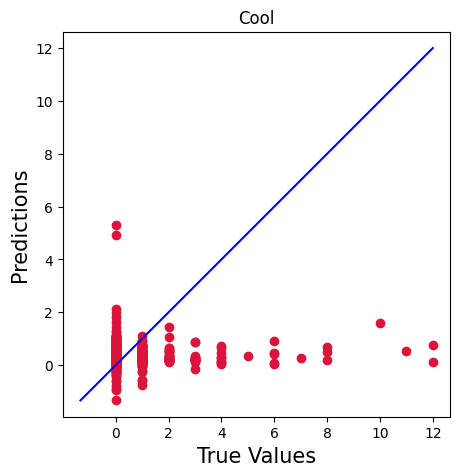

In [1081]:
plt.figure(figsize=(5,5))
plt.scatter(test['cool'], predictCool, c='crimson')
p1 = max(max(predictCool), max(test['cool']))
p2 = min(min(predictCool), min(test['cool']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title('Cool')
plt.show()

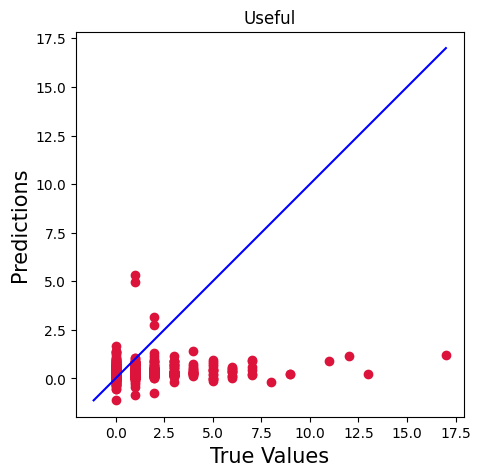

In [1082]:
plt.figure(figsize=(5,5))
plt.scatter(test['useful'], predictUseful, c='crimson')
p1 = max(max(predictUseful), max(test['useful']))
p2 = min(min(predictUseful), min(test['useful']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title('Useful')
plt.show()

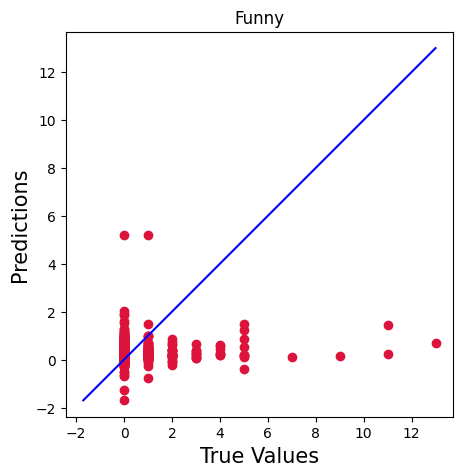

In [1083]:
plt.figure(figsize=(5,5))
plt.scatter(test['funny'], predictFunny, c='crimson')
p1 = max(max(predictFunny), max(test['funny']))
p2 = min(min(predictFunny), min(test['funny']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title('Funny')
plt.show()